## 1.라이브러리 선언 

In [1]:
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 ##

C:\Users\SMART-24\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2.데이터 불러오기 및 정제

In [2]:
imageList = [] ## 실제 이미지
labelList = [] ## 정답지

###데이터를 불러오려면 전략이 필요하다.
basedir = "../images/mnist/trainingSet/"

categories = os.listdir(basedir)
IMG_SIZE = 28 ##왜 고정하냐면 내가 다루고 있는 이미지의 해상도를 확인해야하기 때문에 정의
for i in range(0,len(categories)):
    ##디렉토리 폴더와 다른 폴더와 이어주고 싶을 때(경로) 이렇게 사용할 수 있다.(경로를 이어준다)
    ##이미지 경로 넣어주기
    pathDirectory = os.path.join(basedir,categories[i])
    pathImages = os.listdir(pathDirectory)
    
    for j in range(0,len(pathImages)):
    ##경로에 이미지 선택 해주기(즉, 이미지 뽑기-하나씩)
        eachImagePath = os.path.join(pathDirectory,pathImages[j])
        
        #########################증요!!!!############################(숫자, 감정, 나이, 성별 등 내가 원하는 형태로 담을 수 있다)
        ##또한 try로 묶어줘야 이상한 이미지를 pass하고 넘어감
        try:
            ## 회색이미지로 변환을 고려해야함
            eachImage = cv2.imread(eachImagePath,cv2.IMREAD_GRAYSCALE)

            ## 크기변환을 고려해야함(28,28) , 속도가 가장 빠름, 식별가능한데 가장 작은사이즈로 변환
            cv2.resize(eachImage,(IMG_SIZE,IMG_SIZE))

            imageList.append(eachImage)

            labelList.append(i)
        except Exception as e:
            print(e,eachImagePath)
            pass
        
##형태 변환 후 imageList의 변환된 형태가 나온다
print(np.array(imageList).shape)
print(np.array(labelList).shape)

OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
 ../images/mnist/trainingSet/0_zero\example.txt
(42000, 28, 28)
(42000,)


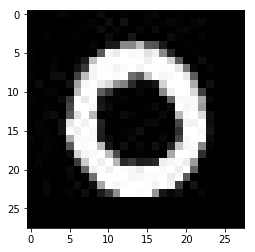

In [3]:
##R,G,B컬러를 알 수 있다.
pd.DataFrame(imageList[0])
##하나를 뽑아서 확인해보기
plt.imshow(imageList[0],cmap="gray")

In [4]:
imageArray = np.array(imageList)
labelArray = np.array(labelList)

In [5]:
##습관적으로 shape을 찍어줘라 봐주기 위해
print(imageArray.shape)
print(labelArray.shape)

(42000, 28, 28)
(42000,)


### 2-1. 데이터 정제는
### 2가지를 할것 (1.데이터 정규화, 2.합성공신경망을 위한 shape 변환 )

In [6]:
##데이터 정규화
refinedImages = imageArray.astype(float)/255.0

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
trainingData_features,\
validData_features,\
trainingData_labels,\
validData_labels = \
train_test_split(refinedImages,labelArray,test_size=0.3,random_state=2)

In [9]:
##softmax는 여러개의 카테고리를 답지가 여러개로 해준다(그 합은 1입) 때문에 원 핫 인코딩을 해줘야한다.
##엑티베이션펑션은 렐수, 비이너리, 소프트백스
##소프트맥스가 하는 역활이 전체 클래스의 총합을 1이 되게한다

from tensorflow.keras.utils import to_categorical

trainingData_labels_one = to_categorical(trainingData_labels)
validData_labels_one = to_categorical(validData_labels)
trainingData_labels_one[15000]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [10]:
##원,핫,인코딩은 인버스 하는 방법은 np.argmax로 사용
np.argmax(trainingData_labels_one[15000])

2

In [11]:
##차원을 늘려준다. -> 합성곱 신경망을 사용하기 위해서
trainingData_features = trainingData_features.reshape(len(trainingData_features),IMG_SIZE,IMG_SIZE,1)
validData_features = validData_features.reshape(len(validData_features),IMG_SIZE,IMG_SIZE,1)

In [12]:
print(trainingData_features.shape)
print(validData_features.shape)

(29400, 28, 28, 1)
(12600, 28, 28, 1)


## 3.모델 생성 

In [13]:
from tensorflow import keras
from tensorflow.keras import Sequential
##모델을 층층이 하나씩 쌓아가겠다.
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
## Dense는 기본 레이어, Conv 합성곱 신경망의 feature를 몇개 쓸꺼냐에 대한 레이어, Max는 기우릴수도 있기 때문에 최대값으로 특징을 찾아냄, Dropout은 너무 오버된것을 해소, Flat은 Dense레이어를 쓰기위한것

##합성곱신경망은 행열 곱연산으로 필터의 값이 있는지 알아낸다. 만약 있다면 어느위치에 있다라는 것이 표현된 없다면 그냥 비슷한값이 추출
##차원이 하나 필요한 이유가 원래는 28*28짜리가 같은애들이 점점 누적되기 떄문에

## pip uninstall tensorboard, pip uninstall tensorflow, pip install tensorflow

##특징을 찾는게 합성곱레이어의 키이다.

In [14]:
model = Sequential()

#kernel_size 몇 행렬로 만들것이냐
#padding은 필터를 행렬곱연산을 한다면 사이즈가 줄어든다. 여기서 이미지손실이 발생하는데 기존에 있는 행열사이즈를 맞춰주기 위해 0으로 채운다.
#relu는 데이터의 손실이 없이 사용된다
#무조건 첫번째 데이터는 입력형태를 집어넣어야한다.
input_shape = trainingData_features[0].shape
input_shape

#첫번째 레이어
model.add(Conv2D(filters=32,
                 kernel_size=3,
                 padding="same",
                 activation="relu",
                 input_shape=input_shape))

#두번째 레리어
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 padding="same",
                 activation="relu"))

########################################
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 padding="same",
                 activation="relu"))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dropout(0.8))

model.add(Dense(units=len(categories),
               activation="softmax"))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0

In [26]:
from tensorflow.keras.utils import plot_model

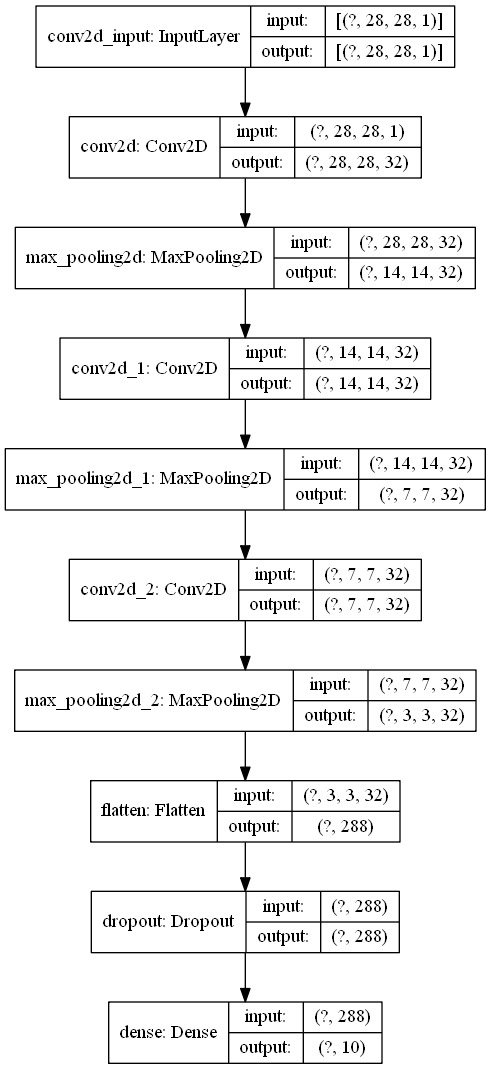

In [27]:
plot_model(model, show_shapes=True)

## 4.모델 컴파일 (평가기준 및 코칭방법 설정)

In [28]:
##이미지 분석은 카테고리분석이 대부분이다.
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

## 5.모델 훈련 

In [29]:
model.fit(x=trainingData_features,
          y=trainingData_labels_one,
         validation_data=(validData_features,validData_labels_one),
          batch_size=32,
         epochs=5
         )

W1101 14:56:36.744064  9968 nn_ops.py:4283] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 29400 samples, validate on 12600 samples
Epoch 1/5


W1101 14:56:37.184089  9968 nn_ops.py:4283] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


29400/29400 [==============================] - 16s 560us/sample - loss: 0.7773 - accuracy: 0.7376 - val_loss: 0.1490 - val_accuracy: 0.9570
Epoch 2/5
29400/29400 [==============================] - 16s 529us/sample - loss: 0.3106 - accuracy: 0.9039 - val_loss: 0.1003 - val_accuracy: 0.9698
Epoch 3/5
29400/29400 [==============================] - 16s 527us/sample - loss: 0.2428 - accuracy: 0.9258 - val_loss: 0.0746 - val_accuracy: 0.9766
Epoch 4/5
29400/29400 [==============================] - 15s 527us/sample - loss: 0.2165 - accuracy: 0.9326 - val_loss: 0.0645 - val_accuracy: 0.9809
Epoch 5/5
29400/29400 [==============================] - 15s 524us/sample - loss: 0.1841 - accuracy: 0.9437 - val_loss: 0.0613 - val_accuracy: 0.9811


## 6.모델 추론(Evaluate)

In [31]:
loss, model_accuracy = model.evaluate(validData_features,validData_labels_one)

12600/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [32]:
model_accuracy

0.9811111

## 7.모델 예측 

In [43]:
test_image = cv2.imread("E:/test_image.jpg",cv2.IMREAD_GRAYSCALE)

print(test_image.shape)

test_image_change = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))

test_image_change.shape

(324, 318)


(28, 28)

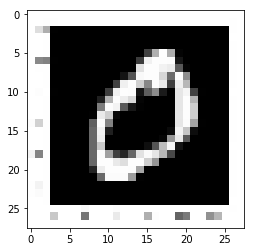

In [45]:
plt.imshow(test_image_change,cmap="gray")

In [53]:
sampleTest = test_image_change.astype(float)/255.0

sampleTest = sampleTest.reshape(1,IMG_SIZE,IMG_SIZE,1)

In [58]:
np.argmax(model.predict(sampleTest))

0

## 참조.모델 저장(구조:Json, 가중치 : h5) 

In [59]:
##구조는 쌓은 레이어(Denes, Max등등)
model_json = model.to_json()

In [60]:
with open("E:/model_mnist_koppo.json","w") as json_file:
    json_file.write(model_json)

In [61]:
model.save_weights("E:/model_mnist_kopo_weight.h5")